In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical

In [2]:
def create_var(x,value = 10):
    locals()[x] = value
    print(locals()[x])

In [3]:
#pose = ("P1R1","P1R2" ,"P1R3",
#       "P2R1","P2R2" ,"P2R3",
#       "P5R1","P5R2" ,"P5R3",
#       "P6R1","P6R2" ,"P6R3",
#       "P7R1","P7R2" ,"P7R3",
#       "P8R1","P8R2" ,"P8R3",
#       "P9R1","P9R2" ,"P9R3",)

pose = ("P1R3",)
out_frame_no = 5
for pose_no in (pose):
    input1 = np.load("C:/Users/lara01/OneDrive - dfki.de/PresSim/Data/FinalData/3DPose/"+pose_no+"_pose.npy")
    input2 = np.load("C:/Users/lara01/OneDrive - dfki.de/PresSim/Data/FinalData/SimulatedPressure/"+pose_no+"_sim.npy")
    output = np.load("C:/Users/lara01/OneDrive - dfki.de/PresSim/Data/FinalData/PressueMap/"+pose_no+"_Sen.npy") 
    print(input1.shape,input2.shape,output.shape)
    buffer1 = np.empty([10,17,3])
    buffer2 = np.empty([10,80,28])
    buffer3 = np.empty([1,80,28])
    in_1 = np.empty([(input1.shape[0]-10),10,17,3,1])
    in_2 = np.empty([(input1.shape[0]-10),10,80,28,1])
    out = np.empty([int((input1.shape[0])-10),1,80,28,1])
    print(in_1.shape,in_2.shape,out.shape)
    for x in range(0,(input1.shape[0]-10), 1):
        buffer3[0] =  output[x+out_frame_no]
        for y in range (10):
            buffer1[y] =  input1[x+y]
            buffer2[y] =  input2[x+y]
        in_1[x] = tf.expand_dims(buffer1, 3)
        in_2[x] = tf.expand_dims(buffer2, 3)
        out[x] = tf.expand_dims(buffer3, 3)
    #in_1f = np.concatenate(in_1f,in_1)
    #in_2f = np.concatenate(in_2f,in_2)
    #out_f = np.concatenate(out_f,out)
    print(in_1.shape,in_2.shape,out.shape)
    #print(in_1f.shape,in_2f.shape,out_f.shape)

(13575, 17, 3) (13575, 80, 28) (13575, 80, 28)
(13565, 10, 17, 3, 1) (13565, 10, 80, 28, 1) (13565, 1, 80, 28, 1)
(13565, 10, 17, 3, 1) (13565, 10, 80, 28, 1) (13565, 1, 80, 28, 1)


In [4]:
print(np.max(out))
print(np.min(out))

4095.0
0.0


In [5]:
#10 frames 3dcnn
droprate = 0.3
a = layers.Input(shape=(10, 17, 3, 1), name="Input_a")
#output1 = layers.Reshape((10, 17, 3))(a)
output1 = layers.Conv3D(filters = 16, kernel_size = (3,3,3),  activation='relu')(a) #no padding, critical for shaping the tensor
# don't change this layer's kernel without adjusting the pooling and upsampling
output1= layers.MaxPooling3D(pool_size=(2, 1, 1))(output1)
output1= layers.UpSampling3D(size=(1, 4, 8))(output1)
output1= layers.Dropout(droprate)(output1)
output1= layers.BatchNormalization()(output1)
output1= layers.Conv3D(32, kernel_size=(3, 3, 3), padding = 'same', activation='relu')(output1)
output1= layers.MaxPooling3D(pool_size=(2, 1, 1))(output1)
output1= layers.Dropout(droprate)(output1)
output1= layers.BatchNormalization()(output1)
output1= layers.UpSampling3D(size=(1, 4, 7))(output1)
output1= layers.Conv3D(1, kernel_size=(3, 3, 3), padding = 'same', activation='relu')(output1)
output1= layers.MaxPooling3D(pool_size=(2, 3, 2))(output1)
#output1 = layers.Reshape((80,28,1))(output1)
model1 = tensorflow.keras.Model(inputs=a,outputs=[output1], name="model_1")
model1.compile(loss='mse',optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics=["mae"])
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_a (InputLayer)        [(None, 10, 17, 3, 1)]    0         
                                                                 
 conv3d (Conv3D)             (None, 8, 15, 1, 16)      448       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 15, 1, 16)     0         
 )                                                               
                                                                 
 up_sampling3d (UpSampling3D  (None, 4, 60, 8, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 60, 8, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 4, 60, 8, 16)     64  

In [6]:
b = layers.Input(shape=(10,80, 28, 1), name="Input_b")
output2 = layers.Conv3D(filters = 16, kernel_size = (3,3,3), padding = 'same', activation='relu')(b)
output2 = layers.MaxPooling3D(pool_size=(2, 1, 1))(output2)
output2 = layers.Dropout(droprate)(output2)
output2 = layers.BatchNormalization()(output2)
output2 = layers.Conv3D(32, kernel_size=(3, 3, 3), padding='same',activation='relu')(output2)
output2 = layers.MaxPooling3D(pool_size=(2, 1, 1))(output2)
output2 = layers.Dropout(droprate)(output2)
output2 = layers.BatchNormalization()(output2)
output2 = layers.Conv3D(16, kernel_size=(2, 3, 3), padding='same',activation='relu')(output2)
output2 = layers.MaxPooling3D(pool_size=(2, 1, 1))(output2)
#output2 = layers.UpSampling3D(size=(5, 4, 4))(output2)
output2 = layers.Conv3D(1, kernel_size=(1, 3, 3), padding='same',activation='relu')(output2)
#output2 = layers.Reshape((80,28,1))(output2)
model2 = tensorflow.keras.Model(inputs=b,outputs=[output2], name="model_2")
model2.compile(loss='mse',optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics=["mae"])
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_b (InputLayer)        [(None, 10, 80, 28, 1)]   0         
                                                                 
 conv3d_3 (Conv3D)           (None, 10, 80, 28, 16)    448       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 5, 80, 28, 16)    0         
 3D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 5, 80, 28, 16)     0         
                                                                 
 batch_normalization_2 (Batc  (None, 5, 80, 28, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 80, 28, 32)     1385

In [7]:
output3 = layers.Concatenate()([output1,output2])
output3 = layers.Conv2D(filters = 32, kernel_size = (2,2), activation='relu', padding = 'same')(output3)
output3 = layers.Conv2D(filters = 8, kernel_size = (2,2), activation='relu', padding = 'same')(output3)
output3 = layers.Conv2D(filters = 1, kernel_size = (1,1), activation='relu', padding = 'same')(output3)
output3 = layers.Reshape((1,80,28))(output3)

In [8]:

model = tensorflow.keras.Model(inputs=[a,b],outputs=[output3], name="regressor_model")
model.compile(loss='mse',optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics=["mae"])
model.summary()

Model: "regressor_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_a (InputLayer)           [(None, 10, 17, 3,   0           []                               
                                1)]                                                               
                                                                                                  
 conv3d (Conv3D)                (None, 8, 15, 1, 16  448         ['Input_a[0][0]']                
                                )                                                                 
                                                                                                  
 Input_b (InputLayer)           [(None, 10, 80, 28,  0           []                               
                                 1)]                                                

                                                                                                  
 conv2d_1 (Conv2D)              (None, 1, 80, 28, 8  1032        ['conv2d[0][0]']                 
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 1, 80, 28, 1  9           ['conv2d_1[0][0]']               
                                )                                                                 
                                                                                                  
 reshape (Reshape)              (None, 1, 80, 28)    0           ['conv2d_2[0][0]']               
                                                                                                  
Total params: 40,563
Trainable params: 40,371
Non-trainable params: 192
_____________________________________

In [9]:
tf.keras.utils.model_to_dot(
    model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    subgraph=False,
    layer_range=None,
    show_layer_activations=False,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [9]:
history = model.fit([in_1,in_2],out,
            batch_size=128,
            epochs=40,
            verbose=1,
            validation_split=0.3
                   )

Epoch 1/40
75/75 [==============================] - 44s 409ms/step - loss: 4927.2231 - mae: 16.0744 - val_loss: 3414.8164 - val_mae: 10.8467
Epoch 2/40
75/75 [==============================] - 29s 384ms/step - loss: 4857.0312 - mae: 17.0858 - val_loss: 3401.2800 - val_mae: 12.8923
Epoch 3/40
75/75 [==============================] - 29s 384ms/step - loss: 4794.9365 - mae: 16.7118 - val_loss: 3398.3311 - val_mae: 14.1748
Epoch 4/40
75/75 [==============================] - 44s 590ms/step - loss: 4744.8086 - mae: 16.4160 - val_loss: 3412.3572 - val_mae: 15.6561
Epoch 5/40
75/75 [==============================] - 29s 384ms/step - loss: 4708.0117 - mae: 16.2696 - val_loss: 3415.0273 - val_mae: 13.2161
Epoch 6/40
75/75 [==============================] - 29s 384ms/step - loss: 4677.9692 - mae: 16.1238 - val_loss: 3537.8191 - val_mae: 19.1130
Epoch 7/40
75/75 [==============================] - 37s 502ms/step - loss: 4662.1841 - mae: 16.0112 - val_loss: 3438.0833 - val_mae: 13.7588
Epoch 8/40
75

In [10]:
pred = model.predict([in_1,in_2]) 

424/424 [==============================] - 11s 24ms/step


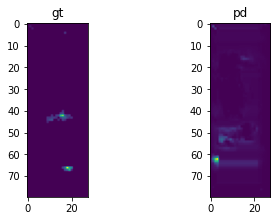

In [11]:
ind = 9800
gt = np.squeeze(out[ind,0])
pd = np.squeeze(pred[ind])
plt.figure(figsize=(6, 3.2))
ax = plt.subplot(1,2,1)
ax.set_title('gt')
plt.imshow(gt)
ax.set_aspect('equal')
ax = plt.subplot(1,2,2)
ax.set_title('pd')
plt.imshow(pd)
ax.set_aspect('equal')
plt.show()

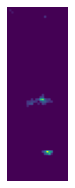

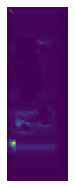

In [12]:
fig = plt.figure(figsize=(6, 3.2))
ax = fig.add_subplot(111)
plt.axis('off')
plt.imshow(gt)
ax.set_aspect('equal')
#cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
#cax.get_xaxis().set_visible(False)
#cax.get_yaxis().set_visible(False)
ax.set(xlabel=None)
#cax.patch.set_alpha(0)
#cax.set_frame_on(False)
plt.savefig('gt.png')
fig = plt.figure(figsize=(6, 3.2))
ax = fig.add_subplot(111)
plt.axis('off')
plt.imshow(pd)
ax.set_aspect('equal')
#cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
#cax.get_xaxis().set_visible(False)
#cax.get_yaxis().set_visible(False)
#cax.patch.set_alpha(0)
#cax.set_frame_on(False)
plt.savefig('pd.png')

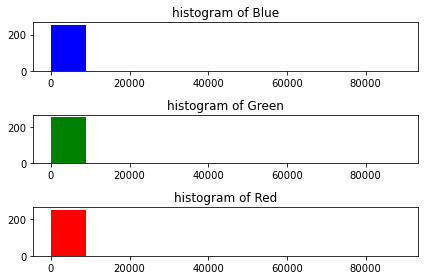

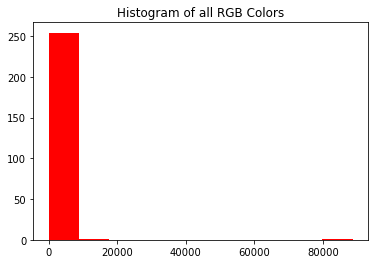

In [16]:
# Get RGB data from image
blue_color_gt = cv2.calcHist([cv2.imread('gt.png')],[0],None,[256],[0,256]) 
red_color_gt = cv2.calcHist([cv2.imread('gt.png')],[1],None,[256],[0,256])
green_color_gt = cv2.calcHist([cv2.imread('gt.png')],[2],None,[256],[0,256])
plt.subplot(3, 1, 1)
plt.title("histogram of Blue")
plt.hist(blue_color_gt, color="blue")
plt.subplot(3, 1, 2)
plt.title("histogram of Green")
plt.hist(green_color_gt, color="green")
plt.subplot(3, 1, 3)
plt.title("histogram of Red")
plt.hist(red_color_gt, color="red")

plt.tight_layout()
plt.show()

# combined histogram
plt.title("Histogram of all RGB Colors")
plt.hist(blue_color_gt, color="blue")
plt.hist(green_color_gt, color="green")
plt.hist(red_color_gt, color="red")
plt.show()


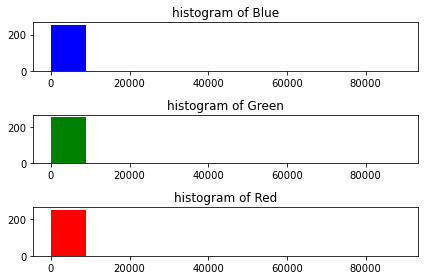

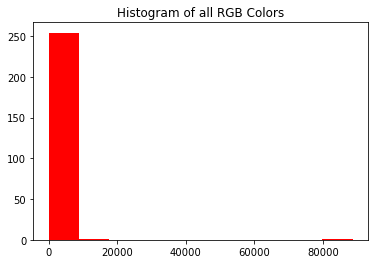

In [17]:
# Get RGB data from image
blue_color_pd = cv2.calcHist([cv2.imread('pd.png')],[0],None,[256],[0,256]) 
red_color_pd = cv2.calcHist([cv2.imread('pd.png')],[1],None,[256],[0,256])
green_color_pd = cv2.calcHist([cv2.imread('pd.png')],[2],None,[256],[0,256])
plt.subplot(3, 1, 1)
plt.title("histogram of Blue")
plt.hist(blue_color_pd, color="blue")
plt.subplot(3, 1, 2)
plt.title("histogram of Green")
plt.hist(green_color_pd, color="green")
plt.subplot(3, 1, 3)
plt.title("histogram of Red")
plt.hist(red_color_pd, color="red")
plt.tight_layout()
plt.show()

# combined histogram
plt.title("Histogram of all RGB Colors")
plt.hist(blue_color_pd, color="blue")
plt.hist(green_color_pd, color="green")
plt.hist(red_color_pd, color="red")
plt.show()


In [18]:
color = ("blue_color","green_color","red_color")
for x in (color):
    if ("blue_color"):
        x = blue_color_gt
        y = blue_color_pd
    elif (x == "green_color"):
        x == green_color_gt
        y = green_color_pd
    elif (x == "red_color"):
        x == red_color_gt
        y = red_color_pd
    intersection = cv2.compareHist(x, y, 2)
    inter_percentage = (intersection/cv2.compareHist(x, x, 2))*100
    print(intersection, inter_percentage)

98729.0 99.36493558776166
98729.0 99.36493558776166
98729.0 99.36493558776166


In [19]:
orb = cv2.ORB_create()

# Now detect the keypoints and compute
# the descriptors for the query image
# and train image
queryKeypoints, queryDescriptors = orb.detectAndCompute(cv2.imread('gt.png'),None)
trainKeypoints, trainDescriptors = orb.detectAndCompute(cv2.imread('pd.png'),None)

# Initialize the Matcher for matching
# the keypoints and then match the
# keypoints
matcher = cv2.BFMatcher()
matches = matcher.match(queryDescriptors,trainDescriptors)

# draw the matches to the final image
# containing both the images the drawMatches()
# function takes both images and keypoints
# and outputs the matched query image with
# its train image
final_img = cv2.drawMatches(cv2.imread('gt.png'), queryKeypoints,
cv2.imread('pd.png'), trainKeypoints, matches[:20],None)

final_img = cv2.resize(final_img, (1000,650))

# Show the final image
cv2.imwrite('keypointa.png',final_img)

True

In [20]:
#https://sewar.readthedocs.io/en/latest/index.html
blur = cv2.imread('pd.png')
org = cv2.imread('gt.png')
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
print("MSE: ", mse(blur,org))
print("RMSE: ", rmse(blur, org))
print("PSNR: ", psnr(blur, org))
print("SSIM: ", ssim(blur, org))
print("UQI: ", uqi(blur, org))
print("MSSSIM: ", msssim(blur, org))
print("ERGAS: ", ergas(blur, org))
print("SCC: ", scc(blur, org))
print("RASE: ", rase(blur, org))
print("SAM: ", sam(blur, org))
print("VIF: ", vifp(blur, org))

MSE:  17.457128958668815
RMSE:  4.1781729211066425
PSNR:  35.711075407385685
SSIM:  (0.9872394773225882, 0.9882572910421504)
UQI:  0.9926587586335426
MSSSIM:  (0.990874458826684+0j)
ERGAS:  324.9891241294578
SCC:  0.04405487116942211
RASE:  46.198981132428464
SAM:  0.015944641529357376
VIF:  0.8751494976581425
